# 3.3 Validation
Information derived from satellite observation is useless without stating it's accuracy. 
This exercise will show you how to validate results obtained on a cloud platforms. 
- Load inference datasets,
- Load ground-truth(in-situ) datasets,
- Select ROI and stations location datasets, 
- Extract point values from station, 
- Perform verification -- binary classification (true or false matching)
- Compute metrics and decide on the usefulness of the inference datasets

In [1]:
import openeo
import numpy as np 
import xarray as xr
import rioxarray as rio 

import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

import pandas as pd
import geopandas as gpd
import folium
from sentinelhub import (SHConfig, SentinelHubRequest, DataCollection, MimeType, CRS, BBox, bbox_to_dimensions, geometry)

In [2]:
config = SHConfig()
config.sh_client_id = %env SH_CLIENT_ID
config.sh_client_secret = %env SH_CLIENT_SECRET

In [3]:
conn = openeo.connect('https://jjdxlu8vwl.execute-api.eu-central-1.amazonaws.com/production')

In [4]:
conn.authenticate_basic(username=config.sh_client_id, password=config.sh_client_secret)

<Connection to 'https://jjdxlu8vwl.execute-api.eu-central-1.amazonaws.com/production/' with BasicBearerAuth>

In [5]:
# Use this for more 
# https://github.com/openEOPlatform/sample-notebooks/blob/main/openEO%20Platfrom%20-%20Basics.ipynb
# https://github.com/Open-EO/openeo-community-examples/tree/main/python

In [6]:
# load NDSI in Zarr format
# NOTE: awaiting Sinergise backend to update the creation of ZARR files

In [7]:
# load catchment area
catchment_outline = gpd.read_file('data/catchment_outline.geojson')
# catchment_outline_json = catchment_outline.to_json()
# bbox = catchment_outline.bounds.iloc[0]
# catchment_outline.geometry

In [8]:
# load snow station datasets from zenodo:: https://zenodo.org/record/5109574
station_df = pd.read_csv("data/data_daily_IT_BZ.csv")
station_df.head()

,Provider,Name,Date,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill
0,IT_BZ,Alliz_Maso_Strimo_Osservatore,1996-01-01,NaN,NaN,NaN,NaN,19.0
1,IT_BZ,Alliz_Maso_Strimo_Osservatore,1996-01-02,NaN,NaN,NaN,NaN,18.0
2,IT_BZ,Alliz_Maso_Strimo_Osservatore,1996-01-03,NaN,NaN,NaN,NaN,18.0
3,IT_BZ,Alliz_Maso_Strimo_Osservatore,1996-01-04,NaN,NaN,NaN,NaN,18.0
4,IT_BZ,Alliz_Maso_Strimo_Osservatore,1996-01-05,NaN,NaN,NaN,NaN,17.0


In [9]:
station_df_meta = pd.read_csv("data/meta_all.csv")
station_df_meta.head()

,Provider,Name,Longitude,Latitude,Elevation,HN_year_start,HN_year_end,HS_year_start,HS_year_end
0,AT_HZB,Absdorf,15.976667,48.401667,182.0,1970.0,2016.0,1970.0,2016.0
1,AT_HZB,Ach_Burghausen,12.846389,48.148889,473.0,1990.0,2016.0,1990.0,2016.0
2,AT_HZB,Admont,14.457222,47.567778,700.0,1970.0,2016.0,1970.0,2016.0
3,AT_HZB,Afritz,13.795556,46.727500,715.0,1970.0,2016.0,1970.0,2016.0
4,AT_HZB,Alberschwende,9.849167,47.458333,717.0,1982.0,2016.0,1982.0,2016.0


In [10]:
full_station = pd.merge(station_df,
                        station_df_meta,
                        how="inner",
                        on=["Provider", "Name"])
full_station = full_station.drop(["HN_year_start", "HN_year_end", "HS_year_start", "HS_year_end"], axis=1)
full_station = full_station.reset_index(drop=True)
full_station.sample(10)

,Provider,Name,Date,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill,Longitude,Latitude,Elevation
434686,IT_BZ,Ortisei_Osservatore,2017-02-10,0.0,3.0,0.0,3.0,3.0,11.672964,46.574044,1180.0
592975,IT_BZ,S_Martino_in_Passiria_Osservatore,1995-06-29,0.0,0.0,0.0,0.0,0.0,11.227909,46.782682,588.0
714136,IT_BZ,Slingia_Osservatore,2010-03-20,NaN,91.0,NaN,91.0,91.0,10.473920,46.704131,1690.0
515414,IT_BZ,Rifiano_Beobachter,2014-02-20,0.0,0.0,0.0,0.0,0.0,11.183607,46.705034,500.0
478160,IT_BZ,Racines_di_Dentro_Osservatore,2001-02-21,NaN,NaN,NaN,NaN,26.0,11.317197,46.866026,1260.0
278566,IT_BZ,Lazfons_Osservatore,1998-09-03,0.0,0.0,0.0,0.0,0.0,11.546139,46.672401,1190.0
657134,IT_BZ,San_Martino_Osservatore,1999-02-25,0.0,24.0,0.0,24.0,24.0,11.414501,46.701049,1365.0
616219,IT_BZ,S_Pancrazio_Osservatore,2019-02-17,0.0,10.0,0.0,10.0,10.0,11.055685,46.564895,810.0
606105,IT_BZ,S_Pancrazio_Osservatore,1991-06-10,NaN,NaN,NaN,NaN,0.0,11.055685,46.564895,810.0
418529,IT_BZ,Ora_Osservatore,2011-11-16,0.0,0.0,0.0,0.0,0.0,11.305017,46.346885,250.0


In [11]:
# convert lat long to geometries
snow_stations = gpd.GeoDataFrame(
    full_station,
    geometry=gpd.points_from_xy(full_station.Longitude, full_station.Latitude),
    crs="EPSG:4326"
)
snow_stations.sample(10)
# snow_stations.head()

,Provider,Name,Date,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill,Longitude,Latitude,Elevation,geometry
472828,IT_BZ,Racines_di_Dentro_Osservatore,1986-07-18,0.0,0.0,0.0,0.0,0.0,11.317197,46.866026,1260.0,POINT (11.31720 46.86603)
687428,IT_BZ,Sesto_Osservatore,2007-02-04,0.0,37.0,0.0,37.0,37.0,12.349964,46.703053,1310.0,POINT (12.34996 46.70305)
680289,IT_BZ,Sesto_Osservatore,1987-07-20,0.0,0.0,0.0,0.0,0.0,12.349964,46.703053,1310.0,POINT (12.34996 46.70305)
193389,IT_BZ,Fleres_Osservatore,1991-06-22,NaN,NaN,NaN,NaN,NaN,11.347034,46.965212,1245.0,POINT (11.34703 46.96521)
632668,IT_BZ,S_Valpurga_d_Ultimo_Osservatore,2007-03-02,0.0,0.0,0.0,0.0,0.0,11.002854,46.547932,1105.0,POINT (11.00285 46.54793)
193112,IT_BZ,Fleres_Osservatore,1990-09-18,NaN,NaN,NaN,NaN,NaN,11.347034,46.965212,1245.0,POINT (11.34703 46.96521)
722313,IT_BZ,Terento_Osservatore,2006-08-09,0.0,0.0,0.0,0.0,0.0,11.793769,46.832116,1240.0,POINT (11.79377 46.83212)
596265,IT_BZ,S_Martino_in_Passiria_Osservatore,2004-07-01,0.0,0.0,0.0,0.0,0.0,11.227909,46.782682,588.0,POINT (11.22791 46.78268)
755447,IT_BZ,Valluzza_Osservatore,1985-04-27,NaN,0.0,NaN,0.0,0.0,11.662810,46.623574,1350.0,POINT (11.66281 46.62357)
221734,IT_BZ,Fortezza_Osservatore,1996-01-28,0.0,0.0,0.0,0.0,0.0,11.632246,46.778304,725.0,POINT (11.63225 46.77830)


In [12]:
# select stations within catchment area
catchment_stations = gpd.sjoin(snow_stations, catchment_outline, op='within')
catchment_stations.head()

/home/conda/users/c06df7d8cc38dff0b6ab13f016d9cda4bb65ebb5cdefbe46dc867e3aa29b6b61-20230801-104751-102087-199-edc-2023.07-01/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,Provider,Name,Date,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill,Longitude,Latitude,...,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT
449985,IT_BZ,Plata_Osservatore,1980-01-01,NaN,NaN,NaN,NaN,26.0,11.176968,46.822847,...,2090012980,334.5,334.5,419.1,419.2,214040804,0,0,3,10988
449986,IT_BZ,Plata_Osservatore,1980-01-02,NaN,NaN,NaN,NaN,25.0,11.176968,46.822847,...,2090012980,334.5,334.5,419.1,419.2,214040804,0,0,3,10988
449987,IT_BZ,Plata_Osservatore,1980-01-03,NaN,NaN,NaN,NaN,25.0,11.176968,46.822847,...,2090012980,334.5,334.5,419.1,419.2,214040804,0,0,3,10988
449988,IT_BZ,Plata_Osservatore,1980-01-04,NaN,NaN,NaN,NaN,25.0,11.176968,46.822847,...,2090012980,334.5,334.5,419.1,419.2,214040804,0,0,3,10988
449989,IT_BZ,Plata_Osservatore,1980-01-05,NaN,NaN,NaN,NaN,27.0,11.176968,46.822847,...,2090012980,334.5,334.5,419.1,419.2,214040804,0,0,3,10988


In [13]:
station_columns = ['Provider', 'Name', 'Date', 'HN', 'HS', 'HN_after_qc', 'HS_after_qc',
       'HS_after_gapfill', 'Longitude', 'Latitude', 'Elevation', 'geometry']

catchment_stations = catchment_stations[station_columns]
catchment_stations

,Provider,Name,Date,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill,Longitude,Latitude,Elevation,geometry
449985,IT_BZ,Plata_Osservatore,1980-01-01,NaN,NaN,NaN,NaN,26.0,11.176968,46.822847,1130.0,POINT (11.17697 46.82285)
449986,IT_BZ,Plata_Osservatore,1980-01-02,NaN,NaN,NaN,NaN,25.0,11.176968,46.822847,1130.0,POINT (11.17697 46.82285)
449987,IT_BZ,Plata_Osservatore,1980-01-03,NaN,NaN,NaN,NaN,25.0,11.176968,46.822847,1130.0,POINT (11.17697 46.82285)
449988,IT_BZ,Plata_Osservatore,1980-01-04,NaN,NaN,NaN,NaN,25.0,11.176968,46.822847,1130.0,POINT (11.17697 46.82285)
449989,IT_BZ,Plata_Osservatore,1980-01-05,NaN,NaN,NaN,NaN,27.0,11.176968,46.822847,1130.0,POINT (11.17697 46.82285)
...,...,...,...,...,...,...,...,...,...,...,...,...
677527,IT_BZ,Scena_Osservatore,2019-12-27,NaN,NaN,NaN,NaN,0.0,11.190831,46.689596,680.0,POINT (11.19083 46.68960)
677528,IT_BZ,Scena_Osservatore,2019-12-28,NaN,NaN,NaN,NaN,0.0,11.190831,46.689596,680.0,POINT (11.19083 46.68960)
677529,IT_BZ,Scena_Osservatore,2019-12-29,NaN,NaN,NaN,NaN,0.0,11.190831,46.689596,680.0,POINT (11.19083 46.68960)
677530,IT_BZ,Scena_Osservatore,2019-12-30,NaN,NaN,NaN,NaN,0.0,11.190831,46.689596,680.0,POINT (11.19083 46.68960)


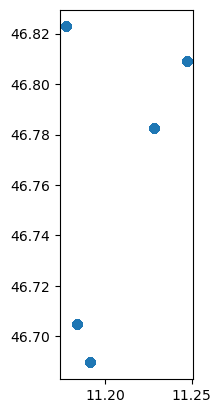

In [14]:
catchment_stations.plot()
catchment_stations.to_file("data/catchment_stations.geojson", driver="GeoJSON")

In [15]:
# binarize snow presence at station level. 
def snow_presence(df):
    '''
    0:: implies no snow
    1:: implies snow presence
    '''
    if df["HS_after_gapfill"] > 0:
        return 1
    elif df["HS_after_gapfill"] <= 0:
        return 0
    else:
        return 0
    
catchment_stations = catchment_stations.assign(snow_presence=catchment_stations.apply(snow_presence, axis=1))

In [16]:
catchment_stations.sample(10)

,Provider,Name,Date,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill,Longitude,Latitude,Elevation,geometry,snow_presence
458113,IT_BZ,Plata_Osservatore,2002-04-03,0.0,0.0,0.0,0.0,0.0,11.176968,46.822847,1130.0,POINT (11.17697 46.82285),0
673375,IT_BZ,Scena_Osservatore,2008-08-14,0.0,0.0,0.0,0.0,0.0,11.190831,46.689596,680.0,POINT (11.19083 46.68960),0
564566,IT_BZ,S_Leonardo_in_Passiria_Osservatore,1997-09-17,NaN,NaN,NaN,NaN,NaN,11.247126,46.809062,644.0,POINT (11.24713 46.80906),0
675625,IT_BZ,Scena_Osservatore,2014-10-12,0.0,0.0,0.0,0.0,0.0,11.190831,46.689596,680.0,POINT (11.19083 46.68960),0
590418,IT_BZ,S_Martino_in_Passiria_Osservatore,1988-06-28,0.0,0.0,0.0,0.0,0.0,11.227909,46.782682,588.0,POINT (11.22791 46.78268),0
593470,IT_BZ,S_Martino_in_Passiria_Osservatore,1996-11-05,0.0,0.0,0.0,0.0,0.0,11.227909,46.782682,588.0,POINT (11.22791 46.78268),0
673228,IT_BZ,Scena_Osservatore,2008-03-20,0.0,0.0,0.0,0.0,0.0,11.190831,46.689596,680.0,POINT (11.19083 46.68960),0
559593,IT_BZ,S_Leonardo_in_Passiria_Osservatore,1984-02-05,NaN,NaN,NaN,NaN,NaN,11.247126,46.809062,644.0,POINT (11.24713 46.80906),0
458119,IT_BZ,Plata_Osservatore,2002-04-09,0.0,0.0,0.0,0.0,0.0,11.176968,46.822847,1130.0,POINT (11.17697 46.82285),0
461564,IT_BZ,Plata_Osservatore,2011-09-14,0.0,0.0,0.0,0.0,0.0,11.176968,46.822847,1130.0,POINT (11.17697 46.82285),0


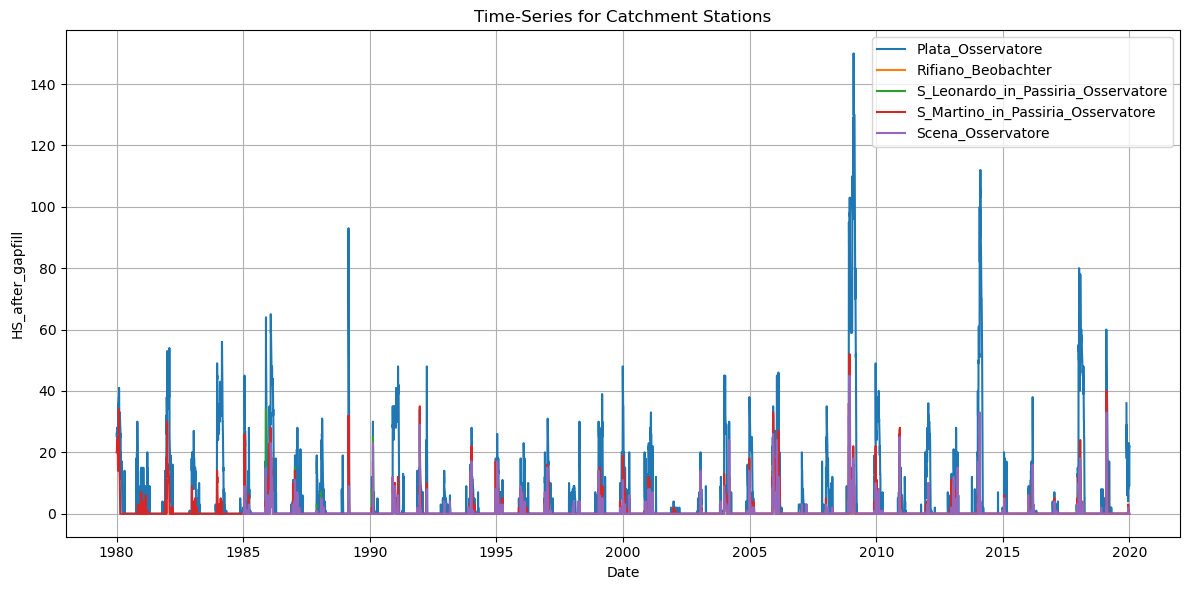

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming catchment_stations is your DataFrame with 'Date', 'Name', and 'HS_after_gapfill' columns

catchment_stations['Date'] = pd.to_datetime(catchment_stations['Date'])
catchment_stations.set_index('Date', inplace=True)

unique_stations = catchment_stations['Name'].unique()

# Create a single plot
plt.figure(figsize=(12, 6))

for station in unique_stations:
    station_data = catchment_stations[catchment_stations['Name'] == station]
    plt.plot(station_data.index, station_data['HS_after_gapfill'], label=station)

plt.title('Time-Series for Catchment Stations')
plt.xlabel('Date')
plt.ylabel('HS_after_gapfill')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Ensures labels are not cut off
plt.show()

In [19]:
# ## TODO: show time-series of the stations
# # Convert 'Date' to datetime format
# # TODO: Reduce Time-series to match the start and end date for the NDSI computation, 
# catchment_stations['Date'] = pd.to_datetime(catchment_stations['Date'])

# # Set 'Date' as the index
# catchment_stations.set_index('Date', inplace=True)

# # Get unique stations
# unique_stations = catchment_stations['Name'].unique()

# # Plot time-series for each station
# for station in unique_stations:
#     station_data = catchment_stations[catchment_stations['Name'] == station]
#     plt.figure(figsize=(10, 4))
#     plt.plot(station_data.index, station_data['HS_after_gapfill'], label=station)
#     plt.title(f'Time-Series for Station: {station}')
#     plt.xlabel('Date')
#     plt.ylabel('HS_after_gapfill')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

In [25]:
# load snow coverage grid
snow_grid = rio.open_rasterio("ndsi_max.tiff")
display(snow_grid.values)

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


array([[[-0.9973475 , -0.8232446 , -0.9129594 , ..., -0.9964602 ,
         -0.9964602 , -0.99631673],
        [-0.9973475 , -0.9973475 , -0.978     , ..., -0.9964602 ,
         -0.9964602 , -0.99631673],
        [-0.99717116, -0.99717116, -0.91286725, ..., -0.8611898 ,
         -0.9495549 , -0.9493294 ],
        ...,
        [-0.5618537 , -0.60047096, -0.581749  , ...,  0.24210078,
          0.23655914,  0.13656186],
        [-0.55116016, -0.60047096, -0.5953033 , ...,  0.463724  ,
          0.4733433 ,  0.35410896],
        [-0.55116016, -0.55057037, -0.55453855, ...,  0.47399852,
          0.4882595 ,  0.37711486]],

       [[-0.8867925 , -0.8376723 , -0.84800965, ..., -0.98275864,
         -0.98275864, -0.983871  ],
        [-0.88087773, -0.9138756 , -0.89369595, ..., -0.98275864,
         -0.98275864, -0.983871  ],
        [-0.9066874 , -0.9678973 , -0.9379043 , ..., -0.98245615,
         -0.98245615, -0.981982  ],
        ...,
        [-0.6065163 , -0.64218616, -0.60522634, ...,  

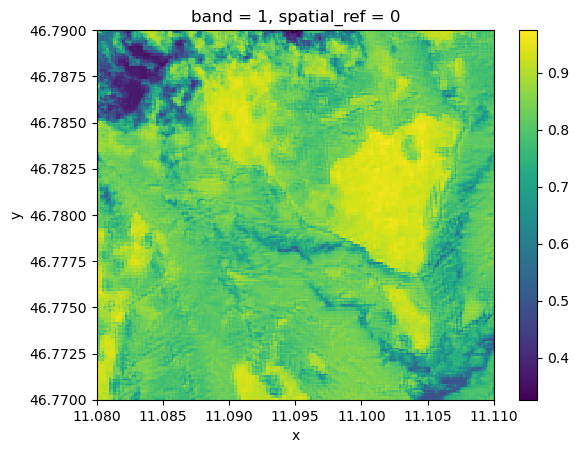

In [21]:
snow_grid.plot()

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


<Axes: >

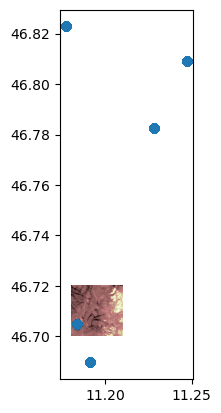

In [24]:
# display points and grid simultaneously
snow_grid_tif = rasterio.open("ndsi_max.tiff")
fig, ax = plt.subplots()
# transform rasterio plot to real world coords
extent = [snow_grid_tif.bounds[0], snow_grid_tif.bounds[2], snow_grid_tif.bounds[1], snow_grid_tif.bounds[3]]
ax = rasterio.plot.show(snow_grid_tif, ax=ax, cmap="pink")
catchment_stations.plot(ax=ax)

In [29]:
# extract values from points
snow_grid_tif = rasterio.open("ndsi_max.tiff")
coord_list = [(x, y) for x, y in zip(catchment_stations["Longitude"], catchment_stations["Latitude"])]
catchment_stations["value"] = [x for x in snow_grid_tif.sample(coord_list)]

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [31]:
catchment_stations.sample(10)
# TODO: split extracted values across time and match the time to station dates as well.

,Provider,Name,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill,Longitude,Latitude,Elevation,geometry,snow_presence,value
Date,,,,,,,,,,,,,
2017-02-20,IT_BZ,Plata_Osservatore,0.0,0.0,0.0,0.0,0.0,11.176968,46.822847,1130.0,POINT (11.17697 46.82285),0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1990-04-20,IT_BZ,Plata_Osservatore,5.0,5.0,5.0,5.0,5.0,11.176968,46.822847,1130.0,POINT (11.17697 46.82285),1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2008-02-15,IT_BZ,Rifiano_Beobachter,0.0,0.0,0.0,0.0,0.0,11.183607,46.705034,500.0,POINT (11.18361 46.70503),0,"[-0.54002625, -0.5084003, -0.99840635, 0.19653..."
2012-02-10,IT_BZ,Plata_Osservatore,0.0,26.0,0.0,26.0,26.0,11.176968,46.822847,1130.0,POINT (11.17697 46.82285),1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1983-08-17,IT_BZ,Plata_Osservatore,0.0,0.0,0.0,0.0,0.0,11.176968,46.822847,1130.0,POINT (11.17697 46.82285),0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2007-05-31,IT_BZ,Rifiano_Beobachter,0.0,0.0,0.0,0.0,0.0,11.183607,46.705034,500.0,POINT (11.18361 46.70503),0,"[-0.54002625, -0.5084003, -0.99840635, 0.19653..."
2005-09-13,IT_BZ,Rifiano_Beobachter,0.0,0.0,0.0,0.0,0.0,11.183607,46.705034,500.0,POINT (11.18361 46.70503),0,"[-0.54002625, -0.5084003, -0.99840635, 0.19653..."
2013-01-15,IT_BZ,Scena_Osservatore,0.0,0.0,0.0,0.0,0.0,11.190831,46.689596,680.0,POINT (11.19083 46.68960),0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2016-10-26,IT_BZ,S_Martino_in_Passiria_Osservatore,0.0,0.0,0.0,0.0,0.0,11.227909,46.782682,588.0,POINT (11.22791 46.78268),0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [51]:
len(np.unique(within_catchment.Date))/365

40.02739726027397

In [ ]:
# set threshold for snow values
# Reference: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndsi/#:~:text=The%20Sentinel%2D2%20normalized%20difference,above%200.42%20are%20usually%20snow.
# values above 0.42 are snow

# snow_grid.values
# np.unique(np.where(snow_grid.values > 0.42, 1, 0), return_counts=True) # i.e. 0 represent not snow and 1 represents snow. 

In [ ]:
# select ROI
# 'https://raw.githubusercontent.com/EO-College/cubes-and-clouds/main/exercises/data/catchment_outline.geojson'
# catchment_outline = gpd.read_file('data/catchment_outline.geojson')
# m = folium.Map(location=[catchment_outline.centroid.y, catchment_outline.centroid.x])
# folium.GeoJson(data=catchment_outline.to_json(), name='catchment').add_to(m)
# m

In [23]:
# data validation
snow_stations.to_csv("station_gdf.csv")
